# Preprocesamiento de Datos
Este notebook se encarga de cargar y preprocesar los datos necesarios para el entrenamiento del modelo.

In [1]:
# Importación de bibliotecas
import cv2
import skimage
import matplotlib.pyplot as plt
import numpy as np
import logging
import os

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configuración del logging
logging.basicConfig(
    filename="./logs/data_preprocessing.log",
    filemode="a",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)


## Funciones de preprocesamiento

## Carga de Datos
Cargamos los datos desde su fuente y verificamos los primeros registros para entender su estructura.


In [2]:
def to_silhouette(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, silhouette = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Invierte la imagen si la media es mayor a 127 (experimental)
    if np.mean(silhouette) > 127:
        silhouette = cv2.bitwise_not(silhouette)
    
    return silhouette


In [3]:
def binarize_with_canny(img, weak_th=None, strong_th=None):
    if img is None:
        logging.error("La imagen no puede ser None.")
        raise ValueError("La imagen no puede ser None")
    
    # Conversión de la imagen a escala de grises
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Reducción de ruido con un filtro gaussiano
    img = cv2.GaussianBlur(img, (5, 5), 1.4)
    
    # Cálculo de los gradientes
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
    
    # Conversión de coordenadas cartesianas a polares
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
    # Establecimiento de umbrales mínimo y máximo
    mag_max = np.max(mag)
    if weak_th is None:
        weak_th = mag_max * 0.1
    if strong_th is None:
        strong_th = mag_max * 0.5
    
    # Aplicación del algoritmo de Canny
    _, binary = cv2.threshold(mag, weak_th, strong_th, cv2.THRESH_BINARY)
    
    return binary


In [4]:
def binarize_with_canny_cv2(img, weak_th=None, strong_th=None):
    if img is None:
        logging.error("La imagen no puede ser None.")
        raise ValueError("La imagen no puede ser None")
    
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) == 2:
        pass
    
    # Aplicación directa del algorimo de Canny de OpenCV
    if weak_th is None:
        weak_th = 100
    if strong_th is None:
        strong_th = 200
    binary = cv2.Canny(img, weak_th, strong_th)
    
    return binary

In [5]:
img = skimage.io.imread("../../datasets/images/a_original.jpg")

In [6]:
# benchmarking
import time

start = time.time()
to_silhouette(img)
print(f"to_silhouette: {time.time() - start:2e}")

start = time.time()
binarize_with_canny(img)
time_manual_canny = time.time() - start

start = time.time()
binarize_with_canny_cv2(img)
time_cv2_canny = time.time() - start

print(f"binarize_with_canny: {time_manual_canny:2e}")
print(f"binarize_with_canny_cv2: {time_cv2_canny:2e}")
print(f"binarize_with_canny_cv2 es {time_manual_canny / time_cv2_canny:2f} veces más rápido que binarize_with_canny")


to_silhouette: 6.849766e-04
binarize_with_canny: 1.871347e-03
binarize_with_canny_cv2: 1.261234e-04
binarize_with_canny_cv2 es 14.837429 veces más rápido que binarize_with_canny


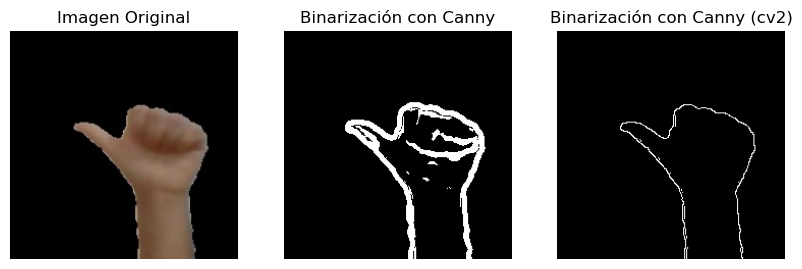

In [7]:
# Cargar una imagen y aplicar el preprocesamiento (descomenta y ajusta la ruta según sea necesario)

silhouette_img = to_silhouette(img)
binary_img = binarize_with_canny(img)
bin2 = binarize_with_canny_cv2(img)
# Mostrar los resultados

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Imagen Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(binary_img, cmap="gray")
plt.title("Binarización con Canny")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(bin2, cmap="gray")
plt.title("Binarización con Canny (cv2)")
plt.axis("off")

plt.show()


In [8]:
def is_valid_image(file_name):
    return file_name.lower().endswith(('.png', '.jpg', '.jpeg'))

def get_new_image_name(file_name, suffix="_s"):
    name, ext = os.path.splitext(file_name)
    return f"{name}{suffix}{ext}"

def process_and_save_silhouette(img_path, label, output_dir, method="canny"):
    img = cv2.imread(img_path)

    # Seleccionar el método de binarización
    method = method.lower()

    if method == "canny":
        silhouette = binarize_with_canny(img)
    elif method == "canny_cv2":
        silhouette = binarize_with_canny_cv2(img)
    elif method == "silhouette":
        silhouette = to_silhouette(img)

    new_name = get_new_image_name(os.path.basename(img_path))

    # Ruta de salida para guardar la imagen
    save_dir = os.path.join(output_dir, label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, new_name)

    # Guardar la imagen procesada
    cv2.imwrite(save_path, silhouette)
    return silhouette

In [9]:

def save_silhouette(input_dir='augmented_images', output_dir='images_processed', method="canny"):
    images = []
    labels = []

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    logging.info(f"Procesando imágenes en {input_dir} y guardando en {output_dir}.")
    # Procesar cada imagen en el directorio de entrada
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if is_valid_image(file):
                img_path = os.path.join(root, file)
                
                # Extraer la etiqueta de la carpeta
                label = os.path.basename(os.path.dirname(img_path))
                silhouette = process_and_save_silhouette(img_path, label, output_dir, method="canny" )

                # Agregar la imagen y la etiqueta a las listas
                images.append(silhouette)
                labels.append(label)

    logging.info(f'Procesamiento de imágenes completado. {len(images)} imágenes procesadas con {method}.')    
    return images, labels
